# Lecture 4 – Data 100, Summer 2024

Data 100, Summer 2024

[Acknowledgments Page](https://ds100.org/su24/acks/)

A demonstration of advanced `pandas` syntax to accompany Lecture 4.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

### Loading `babynames` Dataset

In [ ]:
import urllib.request
import os.path
import zipfile

data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "data/babynamesbystate.zip"
if not os.path.exists(local_filename): # If the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

ca_name = 'STATE.CA.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header=None, names=field_names)

babynames.tail(10)

### <font color='red'>STOP!</font> Some Quick Exercises

Try to answer the questions in the slides **without** running / looking at the code cells.

What do the following lines of code evaluate to? 

In [ ]:
def a_count(string):
    return string.count('a')
# Use map to apply a_count to each name in the "Name" column
babynames["a_count"] = babynames["Name"].map(a_count)
babynames = babynames.sort_values(by="a_count", ascending=False)
babynames.head()

Now we want to drop the column we just created. How would we do this? 

In [ ]:
babynames.drop("a_count")

In [ ]:
babynames = babynames.drop("a_count")

In [ ]:
babynames = babynames.drop('a_count', axis='columns')

In [ ]:
babynames = babynames.sort_values("Name", key=lambda x: x.str.count('a'), ascending=False)
babynames.head()

## Grouping

Group rows that share a common feature, then aggregate data across the group.

In this example, we count the total number of babies born in each year (considering only a small subset of the data, for simplicity).

<img src="images/groupby.png" width="800"/>

In [ ]:
# The code below uses the full babynames dataset, which is why some numbers are different relative to the diagram
babynames[["Year", "Count"]].groupby("Year").agg(sum)

There are many different aggregation functions we can use, all of which are useful in different applications.

In [ ]:
# What is the earliest year in which each name appeared?
babynames.groupby("Name")[["Year"]].agg(min)

In [ ]:
# What is the largest single-year count of each name?
babynames.groupby("Name")[["Count"]].agg(max)

In this example, we count the total number of babies born each year (considering only a small subset of the data for simplicity).

In [ ]:
babynames.groupby("Year")

In [ ]:
# Selecting only numerical columns to perform grouping on and then grouping by "Year"
babies_by_year = babynames[["Year", "Count"]].groupby("Year").agg(sum)
babies_by_year

What happens if we don't select columns `Year` and `Count` before calling `groupby` and our aggregation function? The results are messy! 

In [ ]:
babynames.groupby("Year").agg(sum)

Alternatively, we could select the relevant columns after calling `groupby` from the "sub-`DataFrames`":

In [ ]:
babynames.groupby("Year")[["Year", "Count"]].agg(sum)

Or, another way (Note: the result is slightly different as it doesn't aggregate the `Year` column despite it being numeric because we are grouping by it): 

In [ ]:
babynames.groupby("Year").sum(numeric_only=True)

In [ ]:
# Plotting baby counts per year
fig = px.line(babies_by_year, y = "Count")
fig.update_layout(font_size = 18, 
                  autosize=False, 
                  width=700, 
                  height=400)

### <font color='red'>STOP!</font> Slido Exercise

Try answering the Slido poll/following question **without** looking at the next image. Try to predict the results of the `groupby` operation shown. 

The answer is below the image.

<img src="images/groupby.png" alt="Image" width="600">

The top ?? will be "hi", the second ?? will be "tx", and the third ?? will be "sd". 

In [ ]:
ds = pd.DataFrame(dict(x=[3, 1, 4, 1, 5, 9, 2, 5, 6], 
                      y=['ak', 'tx', 'fl', 'hi', 'mi', 'ak', 'ca', 'sd', 'nc']), 
                      index=list('ABCABCACB') )
ds

In [ ]:
# Performing groupby on the first column with max aggregation function
ds.groupby(ds.index).agg(max)

In [ ]:
('hi' > 'ak') & ('hi' > 'ca')

### Case Study: Name "Popularity"

In this exercise, let's find the name with sex "F" that has dropped most in popularity since its peak usage in California. We'll start by filtering `babynames` to only include names corresponding to sex "F".

In [ ]:
f_babynames = babynames[babynames["Sex"] == "F"]
f_babynames

In [ ]:
# We sort the data by "Year"
f_babynames = f_babynames.sort_values("Year")
f_babynames

To build our intuition on how to answer our research question, let's visualize the prevalence of the name "Jennifer" over time.

In [ ]:
# We'll talk about how to generate plots in a later lecture
fig = px.line(f_babynames[f_babynames["Name"] == "Jennifer"],
              x="Year", y="Count")

fig.update_layout(font_size = 18, 
                  autosize=False, 
                  width=1000, 
                  height=400)

We'll need a mathematical definition for the change in popularity of a name in California.

Define the metric "Ratio to Peak" (RTP). We'll calculate this as the count of the name in 2022 (the most recent year for which we have data) divided by the largest count of this name in *any* year. 

A demo calculation for Jennifer:

In [ ]:
# In the year with the highest Jennifer count, 6065 Jennifers were born
max_jenn = np.max(f_babynames[f_babynames["Name"] == "Jennifer"]["Count"])
max_jenn

In [ ]:
# Remember that we sorted f_babynames by "Year". 
# This means that grabbing the final entry gives us the most recent count of Jennifers: 114
# In 2022, the most recent year for which we have data, 114 Jennifers were born
curr_jenn = f_babynames[f_babynames["Name"] == "Jennifer"]["Count"].iloc[-1]
curr_jenn

In [ ]:
# Compute the RTP
curr_jenn / max_jenn

We can also write a function that produces the `ratio_to_peak`for a given `Series`. This will allow us to use `.groupby` to speed up our computation for all names in the dataset.

In [ ]:
def ratio_to_peak(series):
    """
    Compute the RTP for a Series containing the counts per year for a single name (year column sorted ascendingly).
    """
    return series.iloc[-1] / np.max(series)

In [ ]:
# Construct a Series containing our Jennifer count data
jenn_counts_ser = f_babynames[f_babynames["Name"] == "Jennifer"]["Count"]

# Then, find the RTP
ratio_to_peak(jenn_counts_ser)

Now, let's use `.groupby` to compute the RTPs for *all* names in the dataset.

You may see a warning message when running the cell below. As discussed in the lecture, `pandas` can't apply an aggregation function to non-numeric data (it doens't make sense to divide "CA" by a number). We can select numerical columns of interest directly.

In [ ]:
rtp_table = f_babynames.groupby("Name")[["Year", "Count"]].agg(ratio_to_peak)
rtp_table

In [ ]:
# Results in a TypeError
# rtp_table = f_babynames.groupby("Name").agg(ratio_to_peak)
# rtp_table

This is the `pandas` equivalent of `.group` from [Data 8](http://data8.org/datascience/_autosummary/datascience.tables.Table.group.html). If we wanted to achieve this same result using the `datascience` library, we would write:

`f_babynames.group("Name", ratio_to_peak)`

### <font color='red'>STOP!</font> Slido Exercise

Try answering the Slido poll/following question **without** running the next cell: Is there a row where `Year` is not equal to 1?

In [ ]:
# Unique values in the Year column
rtp_table["Year"].unique()

In [ ]:
# Dropping the "Year" column
rtp_table.drop("Year", axis="columns", inplace=True)
rtp_table

In [ ]:
# Rename "Count" to "Count RTP" for clarity
rtp_table = rtp_table.rename(columns = {"Count": "Count RTP"})
rtp_table

In [ ]:
# What name has fallen the most in popularity?
rtp_table.sort_values("Count RTP")

We can visualize the decrease in the popularity of the name "Debra:"

In [ ]:
def plot_name(*names):
    fig = px.line(f_babynames[f_babynames["Name"].isin(names)], 
                  x = "Year", y = "Count", color="Name",
                  title=f"Popularity for: {names}")
    fig.update_layout(font_size = 18, 
                  autosize=False, 
                  width=1000, 
                  height=400)
    return fig

plot_name("Debra")

In [ ]:
# Find the 10 names that have decreased the most in popularity
top10 = rtp_table.sort_values("Count RTP").head(10).index
top10

In [ ]:
plot_name(*top10)

For fun, try plotting your name or your friends' names.

### `groupby.size` and `groupby.count()`

In [ ]:
df = pd.DataFrame({'letter':['A', 'A', 'B', 'C', 'C', 'C'], 
                   'num':[1, 2, 3, 4, np.NaN, 4], 
                   'state':[np.NaN, 'tx', 'fl', 'hi', np.NaN, 'ak']})
df

`groupby.size()` returns a `Series`, indexed by the `letter`s that we grouped by, with values denoting the number of rows in each group/sub-DataFrame. It does not care about missing (`NaN`) values.

In [ ]:
df.groupby("letter").size()

`groupby.count()` returns a `DataFrame`, indexed by the `letter`s that we grouped by. Each column represents the number of non-missing values for that `letter`.

In [ ]:
df.groupby("letter").count()

You might recall `value_counts()` function we talked about last week. What's the difference?

In [ ]:
df["letter"].value_counts()

Turns out `value_counts()` does something similar to `groupby.size()`, except that it also sorts the resulting `Series` in descending order.

## Filtering by Group

In [ ]:
# Let's read the elections dataset
elections = pd.read_csv("data/elections.csv")
elections.sample(5)

Let's keep only the elections years where the maximum vote share `%` is less than 45%.

In [ ]:
elections.groupby("Year").filter(lambda sf: sf["%"].max() < 45).head(10)

### `groupby` Puzzle

Assume that we want to know the best election by each party.

#### Attempt #1

We have to be careful when using aggregation functions. For example, the code below might be misinterpreted to say that Woodrow Wilson successfully ran for election in 2020. Why is this happening?

In [ ]:
elections.groupby("Party").agg(max).head(10)

#### Attempt #2

Next, we'll write code that properly returns _the best result by each party_. That is, each row should show the Year, Candidate, Popular Vote, Result, and % for the election in which that party saw its best results (rather than mixing them as in the example above). Here's what the first rows of the correct output should look like:

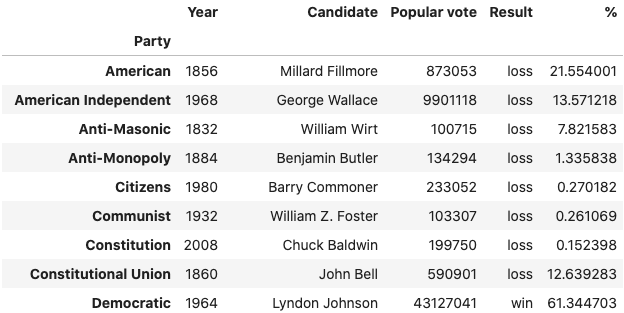

In [ ]:
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.head(8)

In [ ]:
elections_sorted_by_percent.groupby("Party").first()

#### Alternative Solutions

You'll soon discover that with `Pandas` rich tool set, there's typically more than one way to get to the same answer. Each approach has different tradeoffs in terms of readability, performance, memory consumption, complexity, and more. It will take some experience for you to develop a sense of which approach is better for each problem, but you should, in general, try to think if you can at least envision a different solution to a given problem, especially if you find your current solution to be particularly convoluted or hard to read.

Here are a couple of other ways of obtaining the same result (in each case, we only show the top part with `head()`). The first approach uses `groupby` but finds the location of the maximum value via the `idxmax()` method (look up its documentation!).  We then index and sort by `Party` to match the requested formatting:

In [ ]:
elections.groupby("Party")["%"].idxmax()

In [ ]:
# This is the computational part
best_per_party = elections.loc[elections.groupby("Party")["%"].idxmax()]

# This indexes by Party to match the formatting above
best_per_party.set_index('Party').sort_index().head() 

And this one doesn't even use `groupby`! This approach instead uses the `drop_duplicates` method to keep only the last occurrence of of each party after having sorted by "%", which is the best performance.  Again, the 2nd line is purely formatting:

In [ ]:
best_per_party2 = elections.sort_values("%").drop_duplicates(["Party"], keep="last")
best_per_party2.set_index("Party").sort_index().head()  # Formatting

*Challenge:* See if you can find yet another approach that still gives the same answer.

### `DataFrameGroupBy` Objects

The result of `groupby` is not a `DataFrame` or a list of `DataFrame`s. It is instead a special type called a `DataFrameGroupBy`.

In [ ]:
grouped_by_party = elections.groupby("Party")
type(grouped_by_party)

`GroupBy` objects are structured like dictionaries. In fact, we can actually see the dictionaries with the following code:

In [ ]:
grouped_by_party.groups

The `key`s of the dictionary are the groups (in this case, `Party`), and the `value`s are the **indices** of rows belonging to that group. We can access a particular sub-`DataFrame` using `get_group`:

In [ ]:
grouped_by_party.get_group("Socialist")

---

## Pivot Tables

### `Groupby` with multiple columns

We want to build a table showing the total number of babies born of each sex in each year. One way is to `groupby` using both columns of interest:

In [ ]:
babynames.groupby(["Year", "Sex"])[["Count"]].sum().head(6)

### `pivot_table`

In [ ]:
babynames.pivot_table(
    index = "Year", 
    columns = "Sex", 
    values = "Count", 
    aggfunc = np.sum).head(6)

<img src="images/pivote_image.png" alt="Image" width="600">

### `pivot_table` with Multiple values

In [ ]:
babynames.pivot_table(
    index = "Year", 
    columns = "Sex", 
    values = ["Count", "Name"], 
    aggfunc = np.max).head(6)

---

## Join Tables

What if we want to know the popularity of presidential candidates' first names in California in 2022? What can we do?

In [ ]:
elections.head(10)

In [ ]:
babynames_2022 = babynames[babynames["Year"] == 2022]
babynames_2022.head(10)

In [ ]:
elections["First Name"] = elections["Candidate"].str.split(" ").str[0]
elections

Unlike in Data 8, the join function is called `merge` in pandas. `join` in pandas does something slightly different—we won't talk about it in this class.

In [ ]:
merged = pd.merge(left = elections, right = babynames_2022, 
                  left_on = "First Name", right_on = "Name")
merged

In [ ]:
merged.sort_values("Count", ascending=False)